# Введение
В рамках выполнения данного проекта будут исследованы данные яндекс Афиши о заказе пользователей. Ключевым параметром будет исследование связи между различными категориальными данными и числом возвратившихся пользователей. Исследуемый датафрейм будет содержать вот такие столбцы:

- user_id — уникальный идентификатор пользователя, совершившего заказ;
- device_type_canonical — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
- order_id — уникальный идентификатор заказа;
- order_dt — дата создания заказа (используйте данные created_dt_msk );
- order_ts — дата и время создания заказа (используйте данные created_ts_msk );
- currency_code — валюта оплаты;
- revenue — выручка от заказа;
- tickets_count — количество купленных билетов;
- days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- event_id — уникальный идентификатор мероприятия;
- service_name — название билетного оператора;
- event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее);
- region_name — название региона, в котором прошло мероприятие;
- city_name — название города, в котором прошло мероприятие.

  
Целями исследования следующие:
- выявить перспективных клиентов и стимулировтаь их к покупке специальными предложениями
- настраивать рекламу для пользователей с высокой вероятностью возврата
- повысить уровень удержания


# Анализ лояльности пользователей Яндекс Афиши

In [1]:
#импортируем библиотеки
!pip install phik
!pip install dotenv
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt

import phik
from phik import phik_matrix
import seaborn as sns


In [2]:

load_dotenv()

# Формируем строку подключения
connection_string = 'postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    dbname=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [3]:
# выполним запрос в ДБ и запишем данные в датафрейм
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk,
  p.created_ts_msk,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  p.event_id,
  DATE(p.created_dt_msk) - DATE(LAG(p.created_dt_msk) OVER w) AS days_since_prev,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop') 
  AND e.event_type_main != 'фильм'
WINDOW w AS (PARTITION BY p.user_id ORDER BY p.created_dt_msk)
ORDER BY p.user_id;
''' 

df = pd.read_sql_query(query, con=engine) 

In [4]:
#Выведем размер датафрейма - убедимся, что подулючение к БД удалось
df.shape

(290611, 15)

Нам действительно удалось загрузить датафрейм - он содержит  290611 строк и 15 столбцов. Изучим эти данные в дальнейшем

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Сперва стоит изучить структуру данных - размер, типы данных и посмотрим несколько строк.

In [5]:
#сохраним данные об исходном фрейме - его размер и копию
df_initial_len = df.shape[0]
df_initial = df.copy()

In [6]:
# посмотрим на структуру датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   event_id               290611 non-null  int64         
 9   days_since_prev        268678 non-null  float64       
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [7]:
#посмотрим первые строки
df.head(10)

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,event_id,days_since_prev,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,169230,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,237325,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,578454,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,387271,NaN,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,509453,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,500862,19.0,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,201953,NaN,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,265857,NaN,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,271579,16.0,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,516728,NaN,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье


Как мы видим, датафрейм содержит <b>290611 строк</b>.
 Стоит отметить, что датафрейм сожержит довольно мало пропусков - явные Nan находятся только в столбце days_since_prev. Однако в будущем стоит проверить, содержатся ли в данных "неявные" пропуски. Например, "нет данных".
 Особое внимание стоит обратить на типы данных. Во некоторых столбцах они неточны или неверны: 
- <b>created_dt_msk</b> и <b>created_ts_msk</b> имеют тип данных datetime64[ns]. В рамках данного проекта хранить время заказа в наносекундах - избыточно. Для первого столба стоит понизить тип до даты, во втором - до секунд
- <b>days_since_prev</b> представлен типом данных float64. Данный столбец должен хранить число дней. Этому столбцу следует присвоить целочисленный тип данных. Однако тип float64 был присвоен из-за наличия пропусков этого столбца. Сперва следует избавиться от них, и только потом - поменять тип
  Остальные типы данных имеют тип object - это корректно.
  
Помимо работы с типами данных следует также поработать с пропусками и исследовать датафрейм на дубликаты (явные и неявные).

Также стоит выполнить преобразование из тенге в рубли.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [8]:
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
tenge_df = tenge_df.rename(columns={
    'data': 'date',
    'curs': 'rub_per_100_tenge'
})
tenge_df['date'] = pd.to_datetime(tenge_df['date'])
tenge_df = tenge_df[['date', 'rub_per_100_tenge']]

df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
#нормализует коды валют
df['currency_code'] = df['currency_code'].str.upper()

df = df.merge(
    tenge_df,
    left_on='created_dt_msk',
    right_on='date',
    how='left'
)

print("Столбцы после merge:", df.columns.tolist())
print("Пропуски в rub_per_100_tenge:", df['rub_per_100_tenge'].isnull().sum())

df['revenue_rub'] = df.apply(
    lambda row: 
        row['revenue'] if row['currency_code'] == 'RUB'
        else row['revenue'] * (row['rub_per_100_tenge'] / 100),
    axis=1
)

df = df.drop(columns=['date', 'rub_per_100_tenge'])

print("\nПримеры расчёта:")
print(df[['revenue', 'currency_code', 'revenue_rub']].head(10))

Столбцы после merge: ['user_id', 'device_type_canonical', 'order_id', 'created_dt_msk', 'created_ts_msk', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'days_since_prev', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'date', 'rub_per_100_tenge']
Пропуски в rub_per_100_tenge: 0

Примеры расчёта:
   revenue currency_code  revenue_rub
0  1521.94           RUB      1521.94
1   289.45           RUB       289.45
2  1258.57           RUB      1258.57
3     8.49           RUB         8.49
4  1390.41           RUB      1390.41
5   902.74           RUB       902.74
6   917.83           RUB       917.83
7    47.78           RUB        47.78
8    74.84           RUB        74.84
9  1421.91           RUB      1421.91


Изучим полученные данные

In [9]:
df[['revenue_rub', 'revenue', 'currency_code']].sort_values('currency_code').head(15)

,revenue_rub,revenue,currency_code
83697,2056.555460,10338.19,KZT
175995,343.973615,1849.41,KZT
175997,78.793504,414.43,KZT
175998,15.829054,82.19,KZT
175999,343.516355,1773.07,KZT
176000,57.624153,293.29,KZT
176001,80.668706,410.58,KZT
176002,20.242114,101.42,KZT
176003,86.459093,433.19,KZT
176004,30.079757,150.71,KZT


Значения валют были преобразованы и сохранены в новый столбец. Как мы видим, пропусков нет, и данные соответствуют действительности. Таким образом, перевод был сделан верно. Приступим к обработке данных


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

### проверка на пропуски

In [10]:
df_nans_total = df.isna().sum()
df_nans_abs = df_nans_total.sum()
df_nans_mean = df.isna().mean()
df_nans_mean_total = df_nans_abs / df_initial_len
print(f"Пропуски по столбцам:\n {df_nans_total} \nДоля пропусков:\n {df_nans_mean} \nВсего пропусков:\n {df_nans_abs} \nОбщая доля пропусков:\n {df_nans_mean_total}")

Пропуски по столбцам:
 user_id                      0
device_type_canonical        0
order_id                     0
created_dt_msk               0
created_ts_msk               0
currency_code                0
revenue                      0
tickets_count                0
event_id                     0
days_since_prev          21933
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64 
Доля пропусков:
 user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
created_dt_msk           0.000000
created_ts_msk           0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
event_id                 0.000000
days_since_prev          0.075472
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_n

Как мы видим, пропуски расположены только в столбце days_since_prev. Эти данные соответствуют числу дней с момента прошлой покупки пользователя. Пропуски соответствуют пользователям, которые совершили только одну покупку. Следовательно, при удалении этих строк мы потеряем часть данных, отвечающую за разовых покупателей. Это приведет к искажению дальнейшего исследования. Оставим пропуски - но будем их фильтровать при расчетах

In [11]:
#normalize
categorial_cols = ['device_type_canonical',
                  'currency_code',
                   'event_name',
                  'event_type_main',
                  'service_name',
                  'city_name',
                  'region_name']
for col in df[categorial_cols].select_dtypes(include=['object']).columns:
    print(f"\nУникальные значения в '{col}':")
    print(df[col].unique()[:20])  # первые 20 — чтобы не перегружать вывод
    print(f"Всего уникальных: {df[col].nunique()}")


Уникальные значения в 'device_type_canonical':
['mobile' 'desktop']
Всего уникальных: 2

Уникальные значения в 'currency_code':
['RUB' 'KZT']
Всего уникальных: 2

Уникальные значения в 'event_name':
['f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad'
 '40efeb04-81b7-4135-b41f-708ff00cc64c'
 '01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca'
 '2f638715-8844-466c-b43f-378a627c419f'
 '10d805d3-9809-4d8a-834e-225b7d03f95d'
 '9cc55c15-4375-4129-9979-3129688ba1b4'
 '2f98d69f-4e60-4ffc-8f16-e539383526b1'
 '0d876e01-851e-458b-ba61-753e0e0c4063'
 'ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1'
 '11be386f-7cb7-4aa1-a8e4-ba73a29c1af2'
 'bac91ae0-de5d-4d88-8690-6343144b20dc'
 '102fa659-6ca3-4a78-a0a4-20a0339679b5'
 'fcc6c52f-3a46-4d22-8a54-8a7812065aef'
 '0f8e05fc-56be-4bc7-b775-e3cd61ae6fe4'
 'e252d33a-2394-44b8-b11d-f0709a6f0260'
 'ba2dbc92-2c6e-43cb-ae5a-ee5e1c5e4a14'
 'd13f8352-4f10-41e4-b19d-cde15b4d615b'
 '990b8b09-85d8-4ffb-9074-ab5303cd3c33'
 '56d38bb0-bc2b-4b8f-a9a2-be9a90084e38'
 '763161c7-4411-4b4c-86de-8ca8b36d7f1f']

Как мы видим, в категориальных столбцах нет данных, которые по сути означаю пропуски. В столбце event_type_main есть раздел "другое". Вероятно он создан для мероприятий, с уникальным типом, либо тип просто был не указан.

Теперь, после того, как мы избавились от пропусков, можно произвести преобразование типов данных. Описание того, как будет проводиться замена типов, приведено в предыдущем разделе. Однако стоит отметить, что столбец created_dt_msk был приведен к типу datetime в прошлом разделе, так как это было необходимо для корректного расчета валюты. 



- <b>created_dt_msk</b> и <b>created_ts_msk</b> имеют тип данных datetime64[ns]. В рамках данного проекта хранить время заказа в наносекундах - избыточно. Датафрейм содержит много строк, данные такого типа будут занимать много памяти, следует понизить разрядность типа данных этих столбцов.
- <b>days_since_prev</b> представлен типом данных float64. Данный столбец должен хранить число дней. Этому столбцу следует присвоить целочисленный тип данных. Однако тип float64 был присвоен из-за наличия пропусков этого столбца. Сперва следует избавиться от них, и только потом - поменять тип
  Остальные типы данных имеют тип object - это корректно.
  

### Приведение типов

In [12]:
df['days_since_prev'] = df['days_since_prev'].astype('Int64')
df['created_dt_msk'] = df['created_dt_msk'].dt.floor('D')
df['created_ts_msk'] = df['created_ts_msk'].dt.floor('s')

### Проверка на дубликаты

In [13]:
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

Датафрейм не содержит явных дубликатов - изучим, есть ли неявные

я заморочился. проверил неявные. нашёл 4 строчки, которые различаются только устройством. то есть один юзер / секунда в секунду / один тип / одна сумма и т.д. разные только ордер айди и девайс. ну баг же? не зря же всё?

In [14]:
# Исключаем технические столбцы
exclude_cols = {'device_type_canonical', 'order_id'}  # добавь другие, если нужно
key_cols = [col for col in df.columns if col not in exclude_cols]

# Группируем и считаем, сколько строк в каждой группе
dup_groups = df.groupby(key_cols).size().reset_index(name='count')

# Фильтруем только те, где ≥2 строки — потенциальные дубли
potential_dup_groups = dup_groups[dup_groups['count'] > 1]

print(f"Найдено {len(potential_dup_groups)} групп неявных дубликатов.")
print(f'Строки-дубликаты, совпадают все значения, но разные типы устройства и заказы: {potential_dup_groups.head(10)}')

Найдено 32 групп неявных дубликатов.
Строки-дубликаты, совпадают все значения, но разные типы устройства и заказы:                 user_id created_dt_msk      created_ts_msk currency_code  \
11193   06eb7897f65b433     2024-08-13 2024-08-13 16:31:07           RUB   
12003   08199117318954f     2024-07-31 2024-07-31 11:52:06           RUB   
48961   1f49b8de206b285     2024-10-01 2024-10-01 11:32:40           RUB   
50959   206ea45ec11d478     2024-10-29 2024-10-29 16:46:54           RUB   
54005   2564e3703075008     2024-10-30 2024-10-30 10:04:15           RUB   
69860   35c4c43710a1e8c     2024-09-28 2024-09-28 13:43:54           RUB   
78483   3ee7dc2e115847f     2024-06-25 2024-06-25 07:32:08           RUB   
137767  7b525118ae656af     2024-10-28 2024-10-28 08:33:04           RUB   
143176  7eb4fc207ecc10f     2024-08-23 2024-08-23 14:08:19           RUB   
143989  7eb4fc207ecc10f     2024-09-21 2024-09-21 11:43:58           RUB   

        revenue  tickets_count  event_id  days_s

Очевидно, что ситуация, когда пользователь одновременно оплачивает тот же самый заказ с разных устройств - невозможна (совпадение до секунды), следовательно - эти дубликат ошибочны. стоит отбросить лишние

In [15]:
df = df.drop_duplicates(
    subset=key_cols,  # по всем ключевым столбцам
    keep='first'      # можно 'last' — тогда останется последняя
).reset_index(drop=True)

print(f"Было: {df_initial_len} строк → стало: {len(df)} строк")
print(f"Удалено: {df_initial_len - len(df)} строк")

Было: 290611 строк → стало: 290576 строк
Удалено: 35 строк


## исследуем распределение revenue_rub и tickets_count

In [16]:
df['revenue_rub'].describe()

count    290576.000000
mean        555.587609
std         875.525022
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

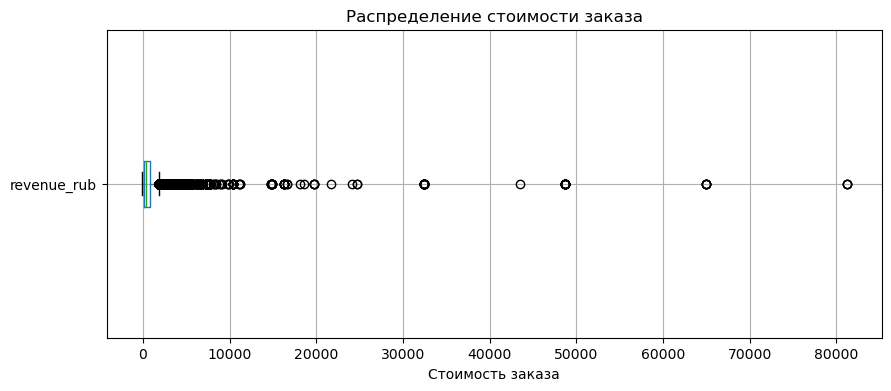

In [17]:
df.boxplot(column='revenue_rub', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение стоимости заказа')
plt.xlabel('Стоимость заказа')
plt.show()

Максимум лежит значительно выше медианы и среднего. Также в данных довольно большое стандартное отклонение - оно даже превышает медиану. Отбросим данные больше 99 квантиля

In [18]:

df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]

In [19]:
df['revenue_rub'].describe()

count    287751.000000
mean        518.040433
std         511.951221
min         -90.760000
25%         111.860000
50%         343.960000
75%         788.660000
max        2628.421739
Name: revenue_rub, dtype: float64

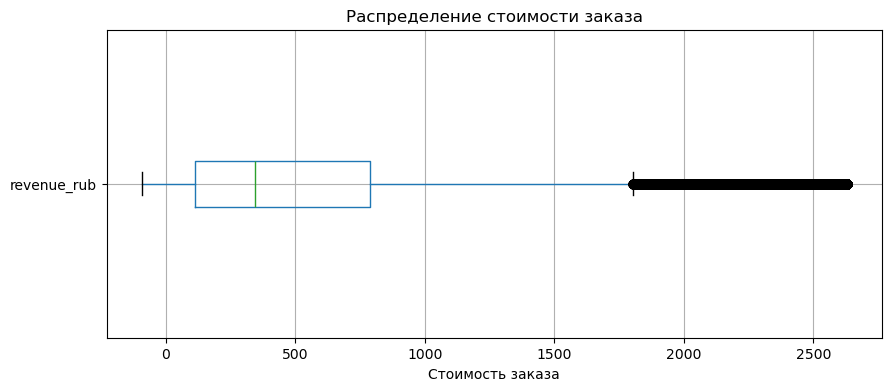

In [20]:
df.boxplot(column='revenue_rub', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение стоимости заказа')
plt.xlabel('Стоимость заказа')
plt.show()

После фильтрации выбросы ушли, стандартное отклоенеие теперь меньше,а  максимальное значение составило 2628. Медиана составляет 343, среднее 518. Стоит отметить, что распределение ненормальное, у данных сильный правый хвос. Однако также присутствуют аномалии в виде отрицательных заказов. Вероятно, так могли быть оформлены возвраты заказов. Посмотрим сколько таких значений и примем решение, что с ними делать. также стоит отметить - выбросов все еще много, и показатель стандартного отклонения все еще высок - стоит снова сократить выбросы в выборке. Это поможет получить более точные результаты в дальнейший расчетах и составить более надежные рекомендации

In [21]:
# Общее количество записей
total = len(df)

# Количество отрицательных значений
negative_count = df[df['revenue_rub'] < 0].shape[0]

# Процент отрицательных
negative_percent = (negative_count / total) * 100

print(f"Всего записей: {total}")
print(f"Отрицательных значений: {negative_count} ({negative_percent:.2f}%)")

Всего записей: 287751
Отрицательных значений: 381 (0.13%)


Отрицательных значений всего 0.13%. Стоит их удалить - они не отображают поведение пользователей, однако все еще могут помешать анализу.

In [22]:
df = df[df['revenue_rub'] >= 0] # отбросим отрицательные
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.95)] 

In [23]:
df['revenue_rub'].describe()

count    273002.00000
mean        444.71136
std         402.27502
min           0.00000
25%         104.88250
50%         317.19000
75%         708.86000
max        1572.76000
Name: revenue_rub, dtype: float64

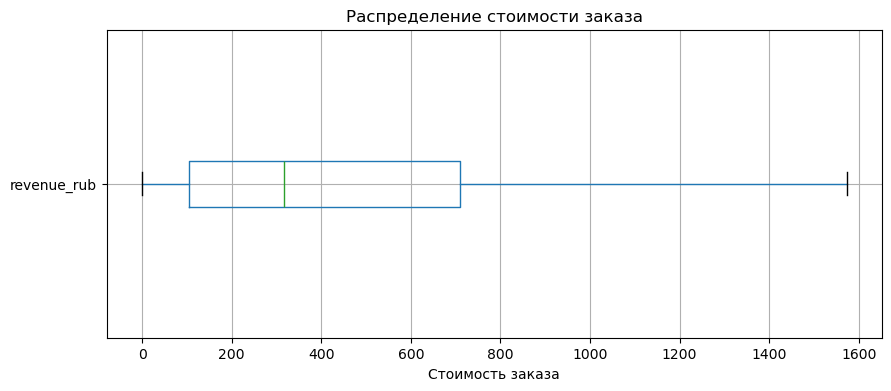

In [24]:
df.boxplot(column='revenue_rub', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение стоимости заказа')
plt.xlabel('Стоимость заказа')
plt.show()

Рассмотрми столбец tickets_count

In [25]:
df['tickets_count'].describe()

count    273002.000000
mean          2.678215
std           1.138118
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

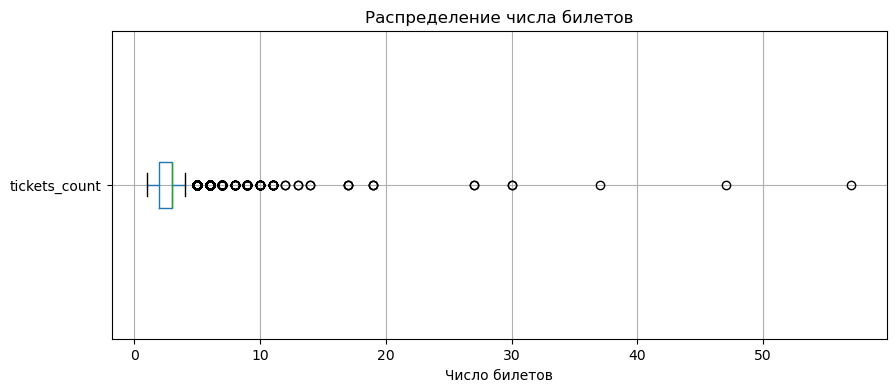

In [26]:
df.boxplot(column='tickets_count', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение числа билетов')
plt.xlabel('Число билетов')
plt.show()

как мы видим, в этом столбце также содержатся выбросы, однако, они не так выражены. Стандартное отклонение равняется 1,16 - это не так много в рамках этого столбца. Медиана равна 3, среднее значение - 2,7. Можно сказать, что распределение близко к нормальному, однако имеет правый хвост за счет выбросов

##  Вывод о предобработке

In [27]:
#После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените,
#в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.
after_len = df.shape[0]
df_final_len = df.shape[0]
df_delta = df_initial_len - df_final_len
df_deleted_part = round(df_delta  *  100 / df_final_len, 2)
print(f"Было удалено {df_delta} строк. Это составило {df_deleted_part}% от исходного датафрейма")
print(f"Строк датафрейма после обработки: {after_len}")

Было удалено 17609 строк. Это составило 6.45% от исходного датафрейма
Строк датафрейма после обработки: 273002


В рамках предобработки данных были проделаны следующие ключевые шаги:
 - Исследован исходный датафрейм. Он содежал 290611 строк.
 - 
 - Создан новый столбце revenue_rub, с типом float64, который содержит данные о сумме заказа в рублях. Исследовано его распределение - обнаружены выбросы, которые были отфильтрованы по 99 процентилю для чистоты дальнейшего анализа. Распределение имеет правый хвост
 - Были обработаны пропуски в столбце days_since_prev. Они заменены на значения-заглушки
 - Столбец days_since_prev был приведен к типу данных Int64, временные столбцы приведены к необходимым форматам. 
 - Были проанализированы дубликаты в датафрейме. Явные дубликаты не были найдены, однако присутствовали неянвые - лишние данные были отброшены.
 - Было также проведено исследование столбцов tickets_count, revenue_rub, days_since_prev. Данные имеют выраженный правый хвост и содержат выбросы. Однако их недостаточно для препятствования анализу, было принято решение их оставить.
 - после удаления дубликатов, обработки пропусков, и фильтрации по процентилю число строк датафрейма поменялись, теперь их 287751. Было удалено 2860 строк, что составило примерно 1% от исходного датафрейма

<div style ="color: blue">

Исправлен раздел предобработки, обоснованы принятые решения, отфильтрованы отрицательные значения

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [28]:
x = df.groupby('user_id')['order_id'].count()
num_users_with_one_order = x.value_counts().get(1, 0)
print(f"Пользователей с одним заказом: {num_users_with_one_order}")

Пользователей с одним заказом: 8272


In [29]:
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'], errors='coerce')

df_sorted = df.sort_values(['user_id', 'created_ts_msk'])

user_profiles_df = df_sorted.groupby('user_id').agg(
    first_order_date=('created_ts_msk', 'first'),
    last_order_date=('created_ts_msk', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_event_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_per_order=('revenue_rub', 'mean'),
    avg_ticket_count=('tickets_count', 'mean'),
    avg_time_between_orders=('days_since_prev', 'mean')
)

user_profiles_df['is_two'] = user_profiles_df['total_orders'] >= 2
user_profiles_df['is_five'] = user_profiles_df['total_orders'] >= 5

user_profiles_df = user_profiles_df.reset_index()

print(f"✅ Создано {len(user_profiles_df)} профилей.")
display(user_profiles_df.head())


✅ Создано 21323 профилей.


,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_event_genre,total_orders,avg_revenue_per_order,avg_ticket_count,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False


In [30]:
user_profiles_df[user_profiles_df['total_orders']==1]['total_orders'].count()

np.int64(8272)

Вывод: Был создан датафрейм с пользователями, рассчитаны основные метрики. Выше приведены первые пять строк. Далее изучим этот датафрейм


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [31]:
print("Общеее число прользователей: ", user_profiles_df.shape[0])
print("Средняя выручка с заказа: ", round(user_profiles_df['avg_revenue_per_order'].mean(), 3))
print("Доля пользователей, совершивший 2 и более заказов: ", round(user_profiles_df['is_two'].sum() / user_profiles_df.shape[0], 3))
print("Доля пользователей, совершивший 5 и более заказов: ", round(user_profiles_df['is_five'].sum() / user_profiles_df.shape[0], 3))

Общеее число прользователей:  21323
Средняя выручка с заказа:  474.281
Доля пользователей, совершивший 2 и более заказов:  0.612
Доля пользователей, совершивший 5 и более заказов:  0.284


Всего имеется информация о 21854 пользователях, средняя выручка с одного заказа - 544,398, Значительная доля пользователей (62%) совершили два и более заказов. 29% пользователей совершили пять и более заказов. Далее рассмотрим статистисческие данные для каждого заказа

In [32]:
 user_profiles_df['avg_time_between_orders'] = pd.to_numeric(
    user_profiles_df['avg_time_between_orders'], 
    errors='coerce' 
)
user_profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21323 entries, 0 to 21322
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21323 non-null  object        
 1   first_order_date         21323 non-null  datetime64[ns]
 2   last_order_date          21323 non-null  datetime64[ns]
 3   first_device             21323 non-null  object        
 4   first_region             21323 non-null  object        
 5   first_partner            21323 non-null  object        
 6   first_event_genre        21323 non-null  object        
 7   total_orders             21323 non-null  int64         
 8   avg_revenue_per_order    21323 non-null  float64       
 9   avg_ticket_count         21323 non-null  float64       
 10  avg_time_between_orders  13277 non-null  Float64       
 11  is_two                   21323 non-null  bool          
 12  is_five                  21323 n

In [33]:
user_profiles_df['total_orders'].describe()

count    21323.000000
mean        12.803170
std        117.039066
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       9691.000000
Name: total_orders, dtype: float64

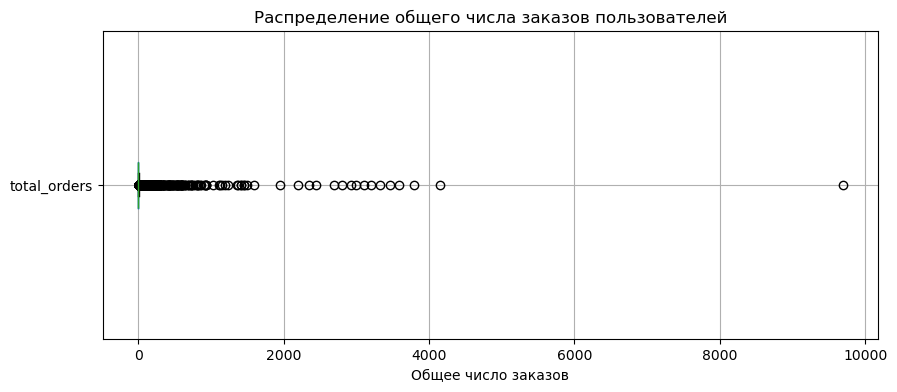

In [34]:
user_profiles_df.boxplot(column='total_orders', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение общего числа заказов пользователей')
plt.xlabel('Общее число заказов')
plt.show()

В данных явно есть выбросы - они явные и будут искажать результаты анализа. Отфильтруем их до 99 квантиля и рассмотрми распределение заново

In [35]:
user_profiles_df = user_profiles_df [user_profiles_df['total_orders'] <= user_profiles_df['total_orders'].quantile(0.99)]

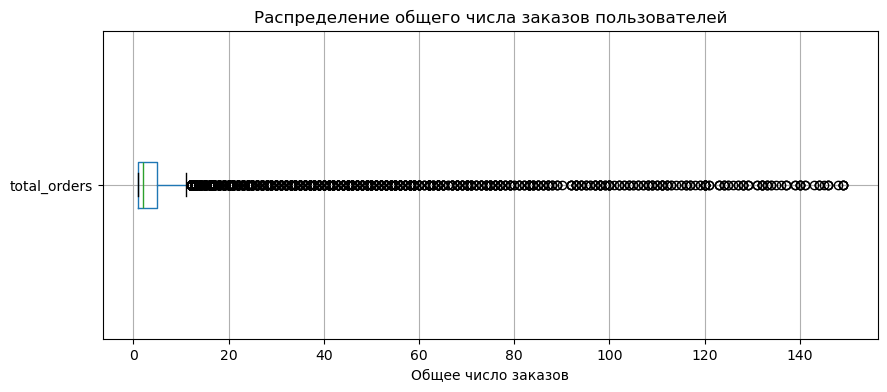

In [36]:
user_profiles_df.boxplot(column='total_orders', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение общего числа заказов пользователей')
plt.xlabel('Общее число заказов')
plt.show()

Не смотря на предыдущую фильтрацию,выбросов все еще много и они достаточно сильно искажают представление о данных, и все еще будут мешать анализу. ОТбросим до 95 квантиля

In [37]:
user_profiles_df = user_profiles_df [user_profiles_df['total_orders'] <= user_profiles_df['total_orders'].quantile(0.95)]

In [38]:
user_profiles_df['total_orders'].describe()

count    20061.000000
mean         3.725936
std          4.389642
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: total_orders, dtype: float64

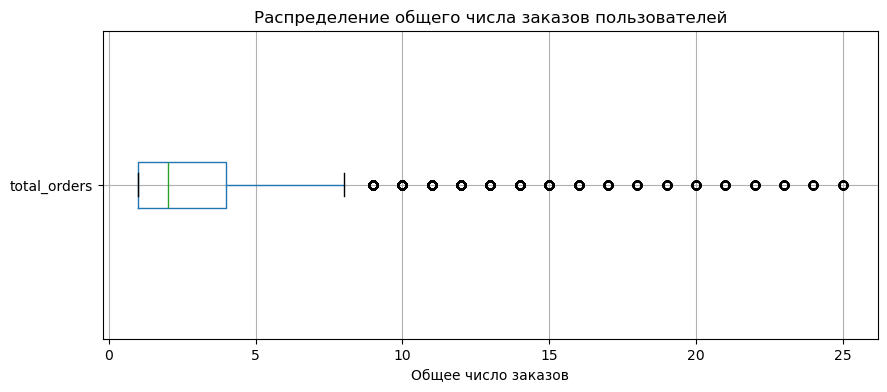

In [39]:
user_profiles_df.boxplot(column='total_orders', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение общего числа заказов пользователей')
plt.xlabel('Общее число заказов')
plt.show()

Данные были отброшены до 95 квантиля. Теперь выбросов немного и они не мешают анализу. Судя по данному распределению, распределение имеет левый хвост и не является нормальным.

In [40]:
user_profiles_df['avg_ticket_count'].describe()

count    20061.000000
mean         2.678258
std          0.919374
min          1.000000
25%          2.000000
50%          2.666667
75%          3.000000
max         11.000000
Name: avg_ticket_count, dtype: float64

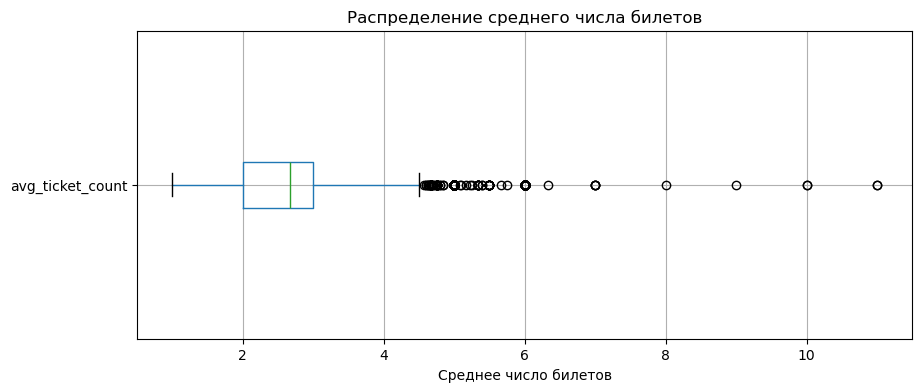

In [41]:
user_profiles_df.boxplot(column='avg_ticket_count', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение среднего числа билетов')
plt.xlabel('Среднее число билетов')
plt.show()

Распределение среднего числа билетов не имеет явных выбросов или аномалий. Есть пользователи с большим числом билетов в заказе, однако их не много. В целом распределение очень близко к нормальному. Медиана лежит около 3х, то есть половина пользователей совершает покупку Большего числа билетов. Также стоит отметить, что медиана находится недалеко от 3 квартиля, то есть данные имеют небольшой разброс

In [42]:
user_profiles_df[user_profiles_df['avg_time_between_orders'] > -1]['avg_time_between_orders'].describe()

count      12015.0
mean     17.262189
std      23.103814
min            0.0
25%            1.0
50%            9.6
75%           22.5
max          148.0
Name: avg_time_between_orders, dtype: Float64

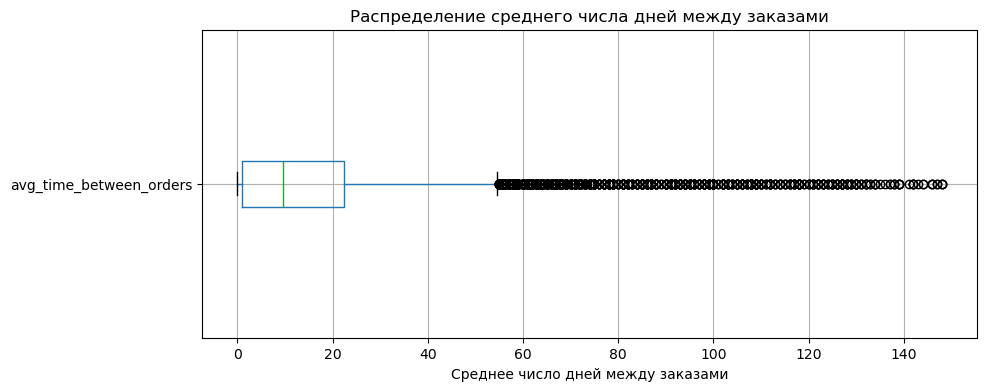

In [43]:
user_profiles_df.boxplot(column='avg_time_between_orders', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение среднего числа дней между заказами')
plt.xlabel('Среднее число дней между заказами')
plt.show()

Данные также имеют много выбросов, способных исказить результаты дальнейшего анализа. Отбросим их доо 95 квантиля

In [44]:
user_profiles_df = user_profiles_df [user_profiles_df['avg_time_between_orders'] <= user_profiles_df['avg_time_between_orders'].quantile(0.95)]

In [45]:
user_profiles_df[user_profiles_df['avg_time_between_orders'] > -1]['avg_time_between_orders'].describe()

count      11421.0
mean      13.25862
std      14.577154
min            0.0
25%            0.5
50%       8.866667
75%      19.714286
max           65.0
Name: avg_time_between_orders, dtype: Float64

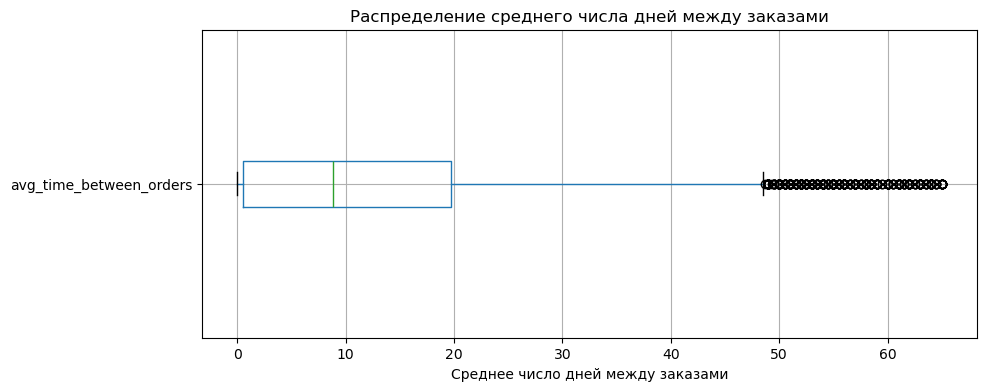

In [46]:
user_profiles_df.boxplot(column='avg_time_between_orders', vert=False, grid=True, figsize = (10,4))
plt.title('Распределение среднего числа дней между заказами')
plt.xlabel('Среднее число дней между заказами')
plt.show()

Вывод: В этом разделе проводилось исследование данных профиля пользователей. Были исследованы следующие показаители и сделаны следующие выводы:
- <b>общее число заказов пользователя</b>. Распределение этого столбца имело множество сильных выбросов. Также в исходных данных было очень большое стандратное отклонение - оно составило 121, что значительно превышала значение медианы. Было принято решение отбросить данные выше 95 процентиля. После этого отклонение составило 4, а медиана - 3. Таким образом, удалось избавиться от аномалий в данных. В целом распределение этой величины имеет выраженный левый хвост, также присутствуют выбросы. Медиана составила 2,75. Среднее - 2.73. Значение среднего и медианы очень близки, что говорит о том, что распределение близко к нормальному.
- <b>Распределение среднего числа билетов</b>. Распределение этого столбца не имеет аномалий. Выросы присутствуют, однако их не настолько много, чтобы исказить данные, было принято решение их оставить. Распределение очень близко к нормальному, однако присуствует правый хвост в данных
- <b>Распределение среднего числа дней меджу заказами</b>. Среднее значение дня между заказами составило 16, медиана - 8. Данные имеют большое стандартное оклоение - около 22. Присутствовали явные выбросы в большом количестве. было принято рещение также сократить выборку до 95 квантиля. После этого медиана составила 8.8, а среднее - 12,8.Отклонение составило около 13. 

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [47]:
users_by_event_total = user_profiles_df.groupby('first_event_genre')['user_id'].count()
users_by_device_total = user_profiles_df.groupby('first_device')['user_id'].count()
users_by_region_total = user_profiles_df.groupby('first_region')['user_id'].count()
users_by_oper_total = user_profiles_df.groupby('first_partner')['user_id'].count()

users_by_event_sum = users_by_event_total.sum()
users_by_device_sum = users_by_device_total.sum()
users_by_region_sum = users_by_region_total.sum()
users_by_oper_sum = users_by_oper_total.sum()

users_by_event_mean = users_by_event_total / users_by_event_sum * 100
users_by_device_mean = users_by_device_total / users_by_device_sum * 100
users_by_region_mean = users_by_region_total / users_by_region_sum * 100
users_by_oper_sum = users_by_oper_total / users_by_oper_sum * 100
print(f"Пользователи по типу первого мероприятия:\n {users_by_event_total},\n их доля: \n{users_by_event_mean}")
print(f"Пользователи по типу первого устройства:\n {users_by_device_total},\n их доля: \n{users_by_device_mean}")
print(f"Пользователи по типу первого региона:\n {users_by_region_total},\n их доля: \n{users_by_region_mean}")
print(f"Пользователи по типу первого оператора:\n {users_by_oper_total},\n их доля: \n{users_by_oper_sum}")

Пользователи по типу первого мероприятия:
 first_event_genre
выставки     237
другое      2829
концерты    4976
спорт        420
стендап      583
театр       2330
ёлки          46
Name: user_id, dtype: int64,
 их доля: 
first_event_genre
выставки     2.075125
другое      24.770160
концерты    43.568864
спорт        3.677436
стендап      5.104632
театр       20.401016
ёлки         0.402767
Name: user_id, dtype: float64
Пользователи по типу первого устройства:
 first_device
desktop    2000
mobile     9421
Name: user_id, dtype: int64,
 их доля: 
first_device
desktop    17.511601
mobile     82.488399
Name: user_id, dtype: float64
Пользователи по типу первого региона:
 first_region
Белоярская область        9
Берестовский округ       14
Берёзовская область      61
Боровлянский край        47
Верховинская область      1
                       ... 
Чистогорская область     44
Шанырский регион        272
Широковская область     681
Яблоневская область     217
Ягодиновская область     36
Name: 

Получили числовые данные - визуализируем их для наглядности

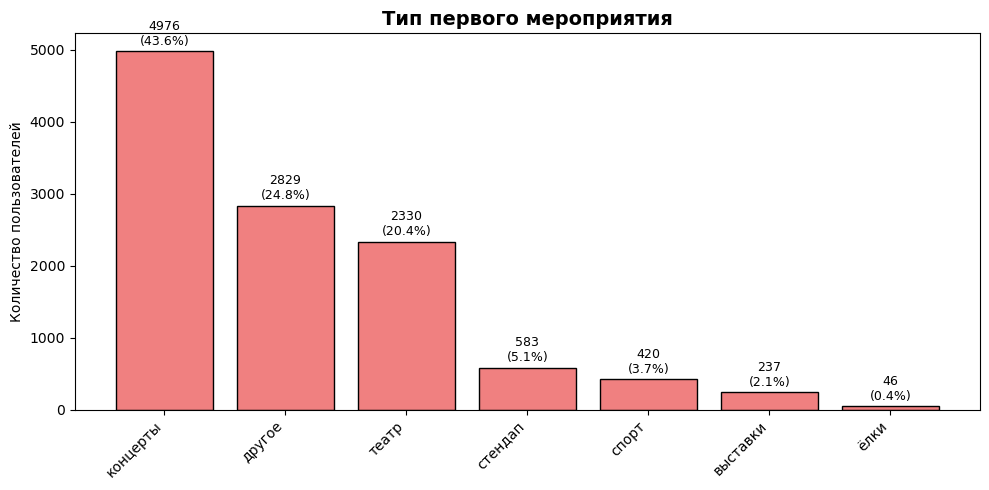

In [48]:

counts = users_by_event_total.sort_values(ascending=False)
shares = users_by_event_mean[counts.index]

# Построение
plt.figure(figsize=(10, 5))
bars = plt.bar(counts.index, counts.values, color='lightcoral', edgecolor='black')
plt.title("Тип первого мероприятия", fontsize=14, weight='bold')
plt.ylabel("Количество пользователей")
plt.xticks(rotation=45, ha='right')

# Подписи
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.01,
             f"{int(height)}\n({shares.iloc[i]:.1f}%)",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

В распределении по типу мероприятия мы видим явное преобладание концертов. Это можно считать точкой входа - около половины пользователей купили билеты на концерт в качестве первого заказа. Всего таких пользователей 5127,что составило 44,6% от всех.

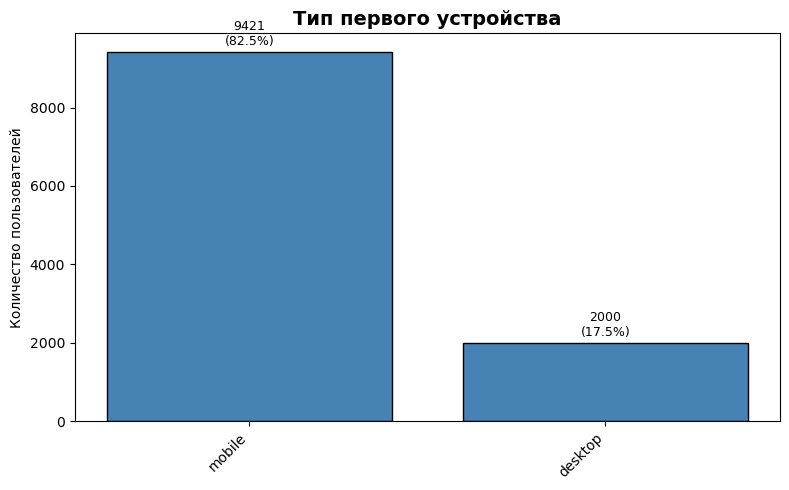

In [49]:
counts = users_by_device_total.sort_values(ascending=False)
shares = users_by_device_mean[counts.index]

plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='steelblue', edgecolor='black')
plt.title("Тип первого устройства", fontsize=14, weight='bold')
plt.ylabel("Количество пользователей")
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.01,
             f"{int(height)}\n({shares.iloc[i]:.1f}%)",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

    Данные неравномерны. Значительная часть пользователей совершили первый заказ с мобильного устройства. Их 9478, что составляет 82,4% от всех пользователей. Это можно считать точкой входа - большинство пользователей открыли для себя сервис с мобильного устройства

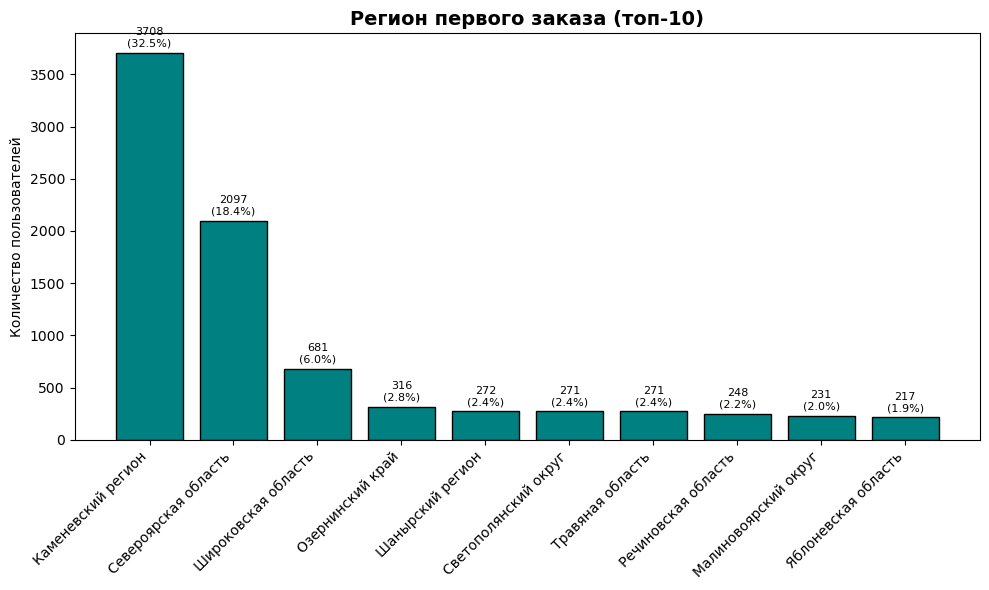

In [50]:
counts = users_by_region_total.sort_values(ascending=False).head(10)
shares = users_by_region_mean[counts.index]

plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, color='teal', edgecolor='black')
plt.title("Регион первого заказа (топ-10)", fontsize=14, weight='bold')
plt.ylabel("Количество пользователей")
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.01,
             f"{int(height)}\n({shares.iloc[i]:.1f}%)",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

    32,8% (3776) пользователей совершили первый заказ из Каменевского раойона, это наиболее популярный регион для совершения первого заказа

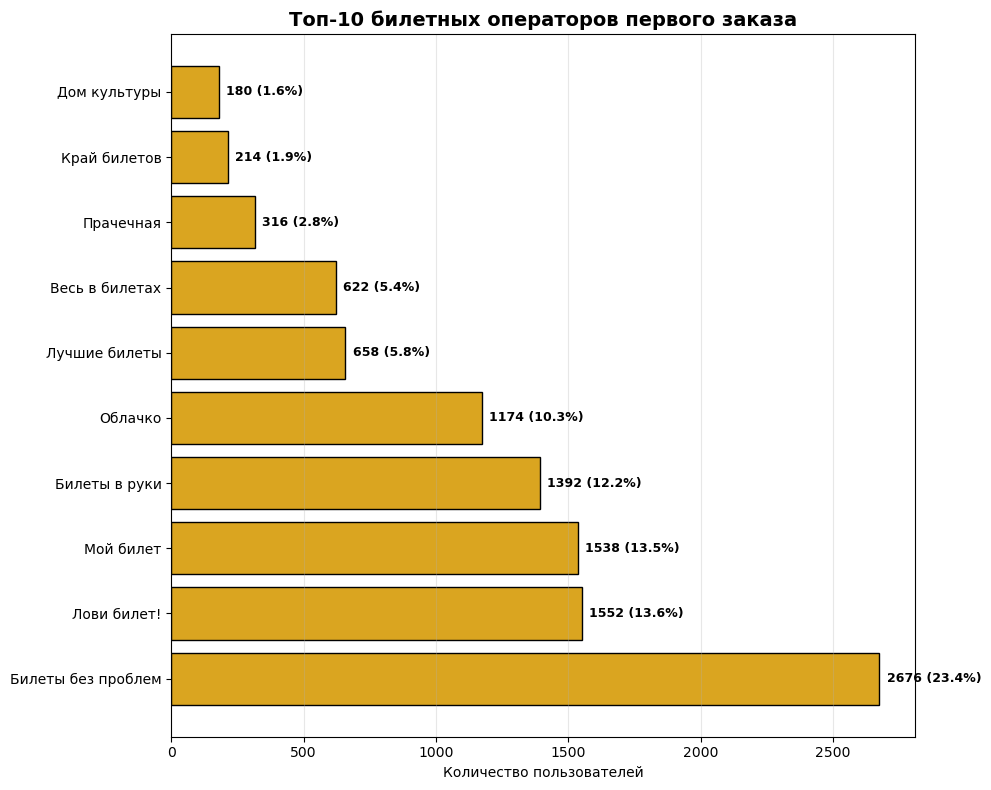

In [51]:

counts = users_by_oper_total.sort_values(ascending=False).head(10)
shares = users_by_oper_sum[counts.index]

# Горизонтальная диаграмма
plt.figure(figsize=(10, 8))
bars = plt.barh(counts.index, counts.values, color='goldenrod', edgecolor='black')

plt.title("Топ-10 билетных операторов первого заказа", fontsize=14, weight='bold')
plt.xlabel("Количество пользователей")
plt.grid(True, axis='x', alpha=0.3)

# Подписи справа от столбцов
for i, bar in enumerate(bars):
    width = bar.get_width()
    share_str = f"{shares.iloc[i]:.1f}%"
    plt.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
             f"{int(width)} ({share_str})",
             va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

Наиболее распространенным организатором-партнером является сервис "Билеты без проблем", пользователей, совершивших первый заказ с их помощью 2695, что составляет 23,4%. Это почти на 10% превышает второго по популярности оператора "Мой билет", где число пользователей составило 1590, а их доля - 13,8%.

Вывод: Данные оказались неравномерными. в каждом разделении на сегменты были обнаружены сегменты, превышающие другие. Так, можно установить "картину" среднестатистической первой покупки. Это пользователь, который заказывает билет на концерт, с помощью мобильного устройства и сервиса "Билеты без проблем" из Каменевского района. Именно эти сегменты оказались наиболее распространенными.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [52]:
def segment_return_rate(df, col_name):
    return (
        df.groupby(col_name)['is_two']
        .agg(
            total_users='count',      
            returned_users='sum',   
            return_rate='mean'       
        )
        .assign(return_rate=lambda x: x['return_rate'] * 100)  # в %
        .sort_values('return_rate', ascending=False)
    )

# Применяем к каждому признаку
event_return = segment_return_rate(user_profiles_df, 'first_event_genre')
device_return = segment_return_rate(user_profiles_df, 'first_device')
region_return = segment_return_rate(user_profiles_df, 'first_region')
partner_return = segment_return_rate(user_profiles_df, 'first_partner')

In [53]:
# Пример для устройств
print("\n Возврат по типу устройства:")
print(device_return[['total_users', 'returned_users', 'return_rate']].round(1).head(10))

# Пример для мероприятий
print("\n Возврат по типу мероприятия:")
print(event_return[['total_users', 'returned_users', 'return_rate']].round(1).head(10))


 Возврат по типу устройства:
              total_users  returned_users  return_rate
first_device                                          
mobile               9421            9277         98.5
desktop              2000            1962         98.1

 Возврат по типу мероприятия:
                   total_users  returned_users  return_rate
first_event_genre                                          
другое                    2829            2810         99.3
выставки                   237             234         98.7
театр                     2330            2292         98.4
спорт                      420             413         98.3
стендап                    583             573         98.3
концерты                  4976            4872         97.9
ёлки                        46              45         97.8


In [54]:

def plot_return_rate_by_size(df, col_name, title, top_n=10, color='steelblue'):
    # Считаем статистику
    stats = (
        df.groupby(col_name)['is_two']
        .agg(
            total_users='count',
            returned_users='sum',
            return_rate='mean'
        )
        .assign(return_rate=lambda x: x['return_rate'] * 100)
        .sort_values('total_users', ascending=False)
        .head(top_n)
    )
    
    # График
    plt.figure(figsize=(10, 6))
    bars = plt.barh(stats.index, stats['return_rate'], color=color, edgecolor='black', alpha=0.85)
    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel("Доля вернувшихся, %", fontsize=12)
    plt.grid(True, axis='x', alpha=0.4)
    
    # Подписи справа: "64.2% (2150)"
    for i, bar in enumerate(bars):
        rate = bar.get_width()
        total = stats.iloc[i]['total_users']
        plt.text(rate + 0.5, bar.get_y() + bar.get_height()/2,
                 f"{rate:.1f}% ({int(total)})",
                 va='center', ha='left', fontsize=10, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Таблица
    print(f"\n📋 {title} (топ-{top_n} по количеству пользователей):")
    print(stats[['total_users', 'returned_users', 'return_rate']].round(1))
    print("-" * 60)
    
    return stats

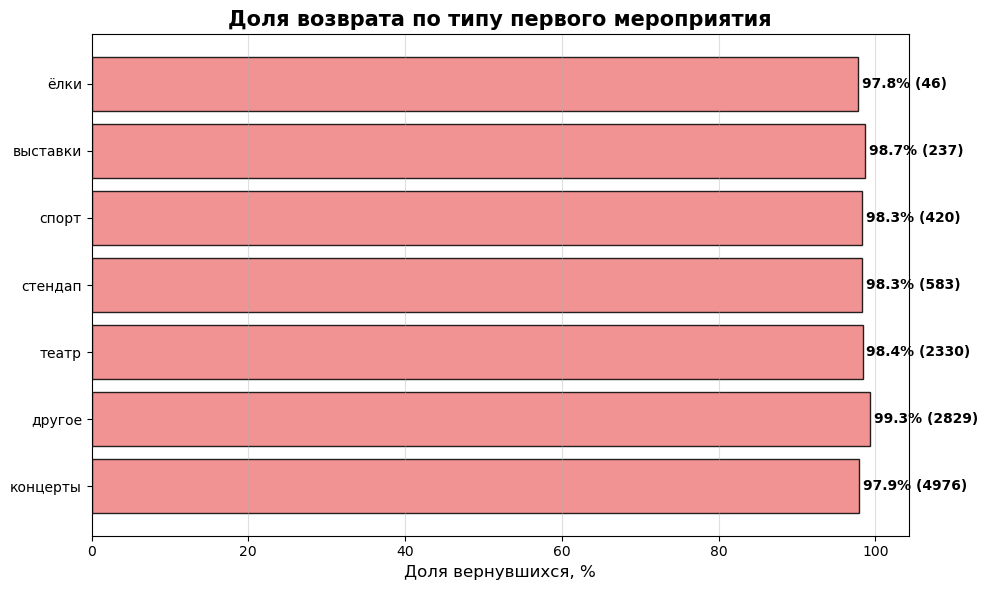


📋 Доля возврата по типу первого мероприятия (топ-10 по количеству пользователей):
                   total_users  returned_users  return_rate
first_event_genre                                          
концерты                  4976            4872         97.9
другое                    2829            2810         99.3
театр                     2330            2292         98.4
стендап                    583             573         98.3
спорт                      420             413         98.3
выставки                   237             234         98.7
ёлки                        46              45         97.8
------------------------------------------------------------


In [55]:
# 1. Тип мероприятия
event_stats = plot_return_rate_by_size(
    user_profiles_df, 
    'first_event_genre', 
    "Доля возврата по типу первого мероприятия",
    top_n=10,
    color='lightcoral'
)

        Было проанализовано поведение пользователей по типу мероприятия, на которое был оформлен первый заказ. В результате выяснено, что наиболее часто возвращаются пользователи, купившие билет на выставки - с частотой 60%. Наименее возвращающаяся категоряи пользователей - купившие билеты на елки - с частотой 53.3%. При этом, если судить по числу пользователей, больше всего вернувшихся средитех, кто купил билет на концерт - таких пользователей 4960.
        Даные отклоняются друг от друга незначительно, однако можно сказать, что точками входа являются билеты на театры и выставки. пользователи, купившие билет на эти мероприятия, наиболее вероятно, купят билет повторно

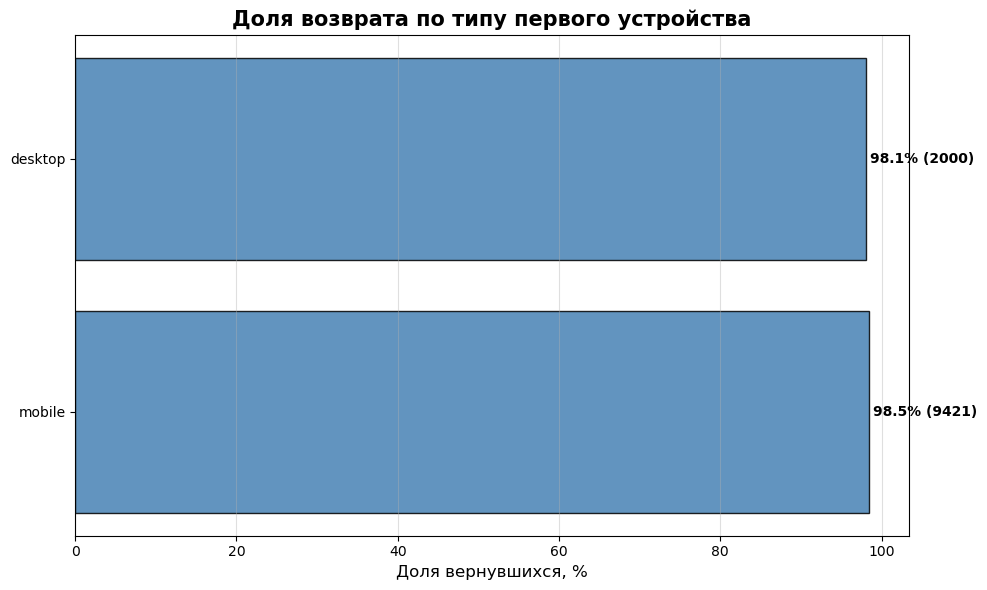


📋 Доля возврата по типу первого устройства (топ-10 по количеству пользователей):
              total_users  returned_users  return_rate
first_device                                          
mobile               9421            9277         98.5
desktop              2000            1962         98.1
------------------------------------------------------------


In [56]:
# 2. Устройство
device_stats = plot_return_rate_by_size(
    user_profiles_df, 
    'first_device', 
    "Доля возврата по типу первого устройства",
    top_n=10,
    color='steelblue'
)

Выше представлено исследование зависимости возврата пользователя от  типа устройства совершения первого заказа. Наиболее часто возвращаются пользователи, совершившие заказ с компьютера, их 59,4%. Однако численно преобладают пользователи, совершившие заказ с мобильных устройств, из них вернулось 9227.

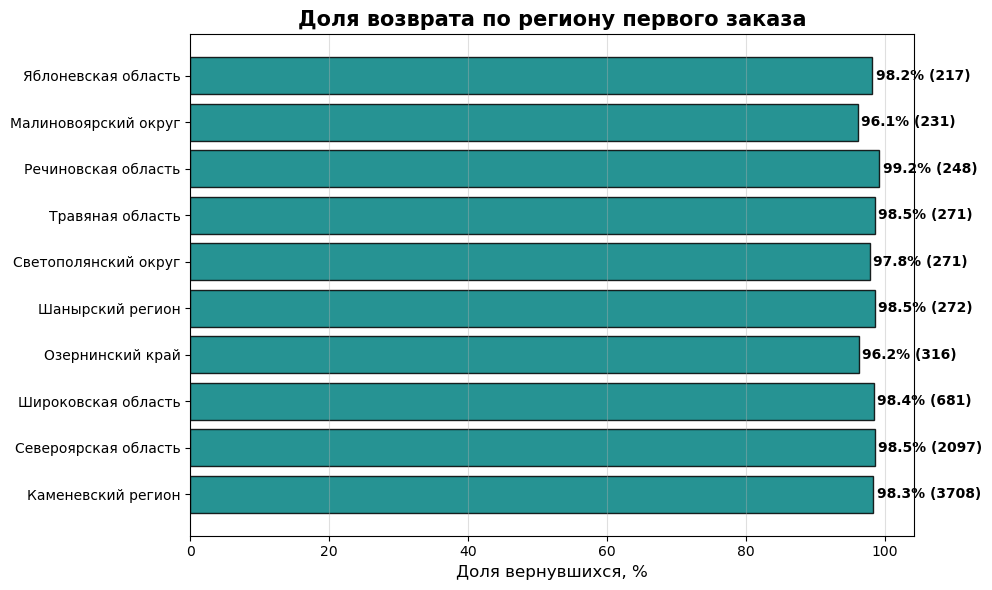


📋 Доля возврата по региону первого заказа (топ-10 по количеству пользователей):
                      total_users  returned_users  return_rate
first_region                                                  
Каменевский регион           3708            3645         98.3
Североярская область         2097            2066         98.5
Широковская область           681             670         98.4
Озернинский край              316             304         96.2
Шанырский регион              272             268         98.5
Светополянский округ          271             265         97.8
Травяная область              271             267         98.5
Речиновская область           248             246         99.2
Малиновоярский округ          231             222         96.1
Яблоневская область           217             213         98.2
------------------------------------------------------------


In [57]:
# 3. Регион (топ-10)
region_stats = plot_return_rate_by_size(
    user_profiles_df, 
    'first_region', 
    "Доля возврата по региону первого заказа",
    top_n=10,
    color='teal'
)

Выше представлены данные о возврате пользователей по регионам. наиболее часто возвращались пользователи Святополянского округа, 62%. Однако численно преобладает Каменевский регион, в нем повторый заказ совершили 6324 пользователя.
данные имеют разброс, наименьшая доля вернувшихся в Озернинском районе, там вернулось всего 52% пользователей, что составило 631 человек.

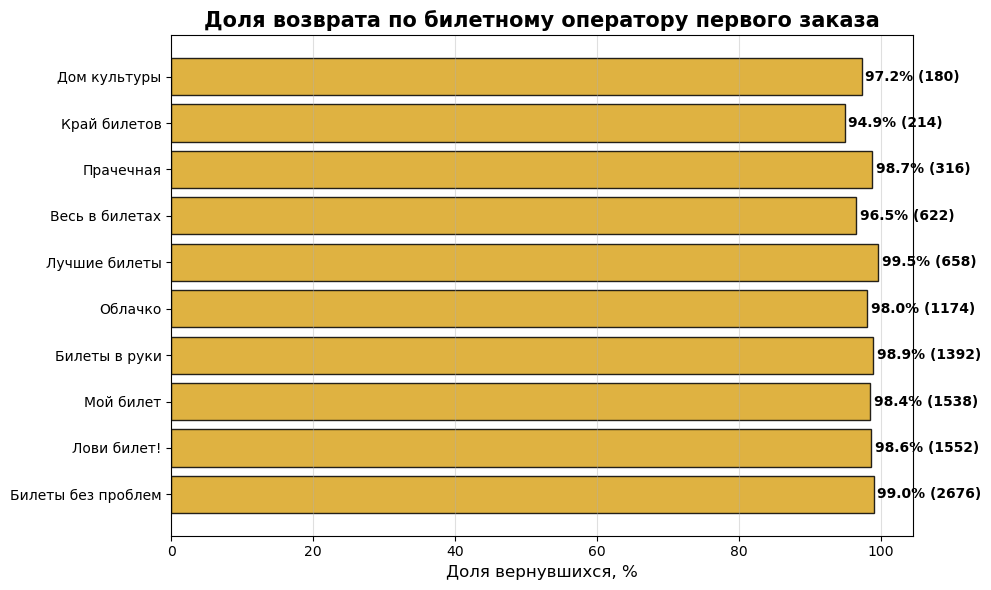


📋 Доля возврата по билетному оператору первого заказа (топ-10 по количеству пользователей):
                    total_users  returned_users  return_rate
first_partner                                               
Билеты без проблем         2676            2648         99.0
Лови билет!                1552            1530         98.6
Мой билет                  1538            1514         98.4
Билеты в руки              1392            1376         98.9
Облачко                    1174            1151         98.0
Лучшие билеты               658             655         99.5
Весь в билетах              622             600         96.5
Прачечная                   316             312         98.7
Край билетов                214             203         94.9
Дом культуры                180             175         97.2
------------------------------------------------------------


In [58]:

# 4. Оператор
partner_stats = plot_return_rate_by_size(
    user_profiles_df, 
    'first_partner', 
    "Доля возврата по билетному оператору первого заказа",
    top_n=10,
    color='goldenrod'
)

Чаще всего возвращались пользователи, впервые восользовавшиеся сервисом "край билетов". Если судить по числу пользователей, больше всего человек верунулось среди пользоветелей сервиса "Билеты без проблем". Таких пользователей 4675. Можно назвать точкой входа покупку билета на первое мероприятие через сервис "Край билетов".

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1 не подтвердилось. Доля вернувшихся пользователей для категории спорт составила 53,5%, а для концертов - 57,5%. Также возьмем во внимание количество вернувшихся клиентов. Вернулось 8602 покупателей билетов на концерты и 752 пользователя, купивших билетов на спорт.
Таким образом можно сказать, чтто гипотеза не только не подтвердилась, но можно также сделать обратное заключение - чаще возвращаются пользователи, купившие билет на концерт

Гипотеза 2 также не подтвердилась. Наибольшее число клиентов сосредоточено в Каменевском районе, таких пользователей там 6324, однако это составляет долю 58%, что не является самым высоким показателем. максимальное значение доли наблюдается в столбце Святополянского района, доля возврата там 62%, а число пользователей при этом меньше, всего - 413 человек. Таким образом, гипотеза о наличии связи между числом пользователей региона и процентом возврата неверна.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


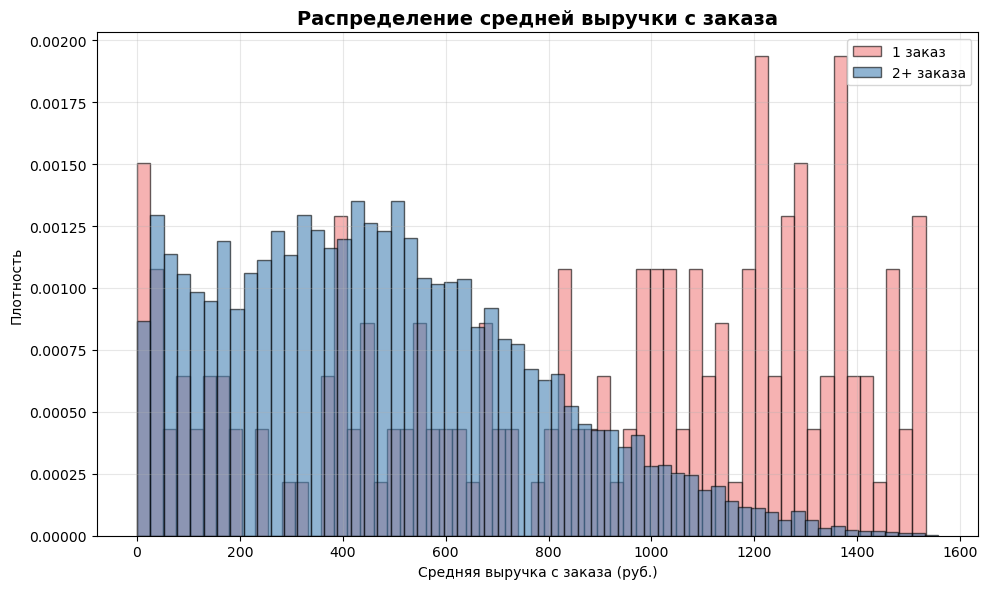

Статистика по средней выручке с заказа:
Один заказ:     медиана = 983₽,  среднее = 862₽,  N = 182
Два и более:    медиана = 443₽,  среднее = 472₽,  N = 11239


In [59]:

one_order = user_profiles_df[user_profiles_df['total_orders'] == 1]['avg_revenue_per_order']
returned = user_profiles_df[user_profiles_df['is_two']]['avg_revenue_per_order']


# Строим гистограммы
plt.figure(figsize=(10, 6))

plt.hist(one_order, bins=60, alpha=0.6, label='1 заказ', color='lightcoral', density=True, edgecolor='black')
plt.hist(returned, bins=60, alpha=0.6, label='2+ заказа', color='steelblue', density=True, edgecolor='black')

plt.title('Распределение средней выручки с заказа', fontsize=14, weight='bold')
plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

# Выведем статистику
print("Статистика по средней выручке с заказа:")
print(f"Один заказ:     медиана = {one_order.median():.0f}₽,  среднее = {one_order.mean():.0f}₽,  N = {len(one_order)}")
print(f"Два и более:    медиана = {returned.median():.0f}₽,  среднее = {returned.mean():.0f}₽,  N = {len(returned)}")

Выше построена гистограмма для пользователей, совершивших один заказ, и для пользоваталей, совершивших больше заказов.  Сразу стоит заметить, что пользователей, совершивших 1 заказ чуть меньше, то есть в основном пользователи, совершившие заказ, вернутся на сервис снова. Распределение не является линейным, оно сильно смещено влево и имеет правый хвост. Распределение вернувшихся пользоватедлей не имеет таких ярко выраженных пиков, однако также смешено влево и имеет правый хвост. Оно не является нормальным. Значения медианы совпадают для обоих категорий совпадает и равно 545 рубля. При этом значение медианы у пользователей, совершивших два и более заказов чуть выше. Так как распределения не являются нормальными, судить стоит по медиане. Можно сделать вывод, что пользователи, совершившие два и более заказов имеют более высокий средний чек в среднем.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


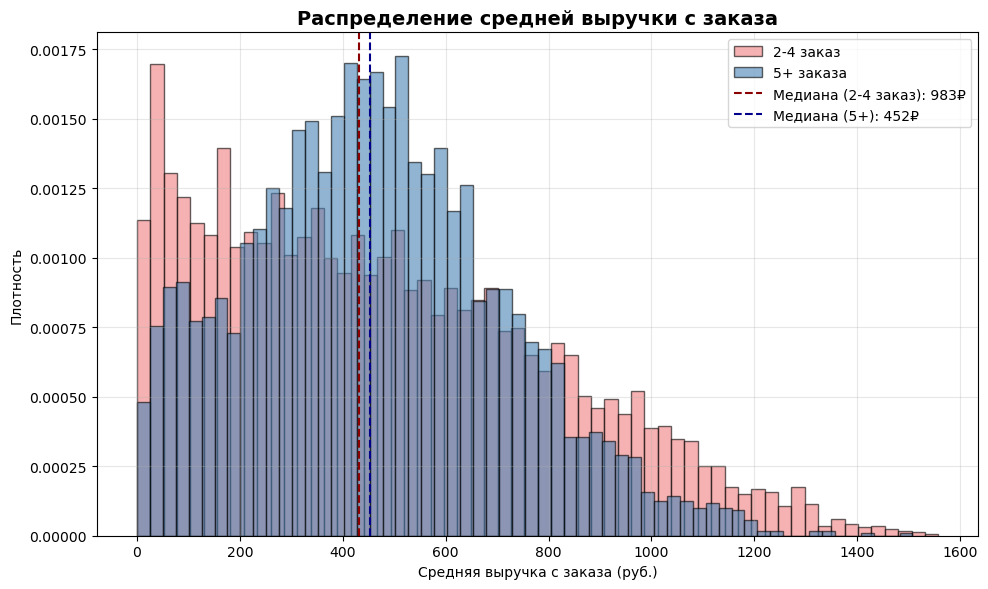

Статистика по средней выручке с заказа:
2-4 заказа:     медиана = 432₽,  среднее = 477₽,  N = 182
Пять и более:    медиана = 452₽,  среднее = 464₽,  N = 11239


In [60]:

two_order = user_profiles_df[(user_profiles_df['is_two'] & ~user_profiles_df['is_five'])]['avg_revenue_per_order']
five_orders = user_profiles_df[user_profiles_df['is_five']]['avg_revenue_per_order']


# Строим гистограммы
plt.figure(figsize=(10, 6))

plt.hist(two_order, bins=60, alpha=0.6, label='2-4 заказ', color='lightcoral', density=True, edgecolor='black')
plt.hist(five_orders, bins=60, alpha=0.6, label='5+ заказа', color='steelblue', density=True, edgecolor='black')

plt.title('Распределение средней выручки с заказа', fontsize=14, weight='bold')
plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.axvline(two_order.median(), color='darkred', linestyle='--', label=f'Медиана (2-4 заказ): {one_order.median():.0f}₽')
plt.axvline(five_orders.median(), color='darkblue', linestyle='--', label=f'Медиана (5+): {five_orders.median():.0f}₽')

plt.legend()
plt.tight_layout()
plt.show()

# Выведем статистику
print("Статистика по средней выручке с заказа:")
print(f"2-4 заказа:     медиана = {two_order.median():.0f}₽,  среднее = {two_order.mean():.0f}₽,  N = {len(one_order)}")
print(f"Пять и более:    медиана = {five_orders.median():.0f}₽,  среднее = {five_orders.mean():.0f}₽,  N = {len(returned)}")

        На диаграмме выше мы видим распределения для пользователей, совершивших 2-4 и пять и более заказов. Распределение пользователей чуть смещено вправо, Большинство пользователей соврешили заказы по более низкой цене,чем пользователи, совершившие пять и больше. Медиана для 2-4 заказов составила 460 рублей, среднее - 548. Для пользователей, совершивших 5+ заказов, распределение чуть ближе к нормальному, имеет ярко выраженный пик, однако присутствует правый хвост. Медиана этого распределения равна 514, а среднее - 543. Медианы и среднее незначительно отклоняются друг от друга, однако пользователи, совершившие 5 и более заказов, покупают заказы на чуть большую сумму. Также заметим, что таких пользователей примерно на 3 тысячи больше

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [61]:
two_orders = user_profiles_df[
    (user_profiles_df['avg_ticket_count'] >= 1) & 
    (user_profiles_df['avg_ticket_count'] < 2)
].copy()

three_orders = user_profiles_df[
    (user_profiles_df['avg_ticket_count'] >= 2) & 
    (user_profiles_df['avg_ticket_count'] < 3)
].copy()

four_orders = user_profiles_df[
    (user_profiles_df['avg_ticket_count'] >= 3) & 
    (user_profiles_df['avg_ticket_count'] < 5)
].copy()

five_orders = user_profiles_df[user_profiles_df['is_five']].copy()  # 5+ заказов

# Считаем количество пользователей в каждой группе
two_orders_users_count = len(two_orders)
three_orders_users_count = len(three_orders)
four_orders_users_count = len(four_orders)
five_orders_users_count = len(five_orders)

two_returned = round(two_orders[two_orders['total_orders'] > 1].shape[0] / two_orders_users_count , 4)
three_returned = round(three_orders[three_orders['total_orders'] > 1].shape[0] / three_orders_users_count, 4)
four_returned = round(four_orders[four_orders['total_orders'] > 1].shape[0] / four_orders_users_count, 4)
five_returned = round(five_orders[five_orders['total_orders'] > 1].shape[0] / five_orders_users_count, 4)



In [62]:
user_profiles_df['segment'] = pd.cut(
    user_profiles_df['avg_ticket_count'],
    bins=[1, 2, 3, 5, float('inf')],
    labels=['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов'],
    include_lowest=True
)

result = (
    user_profiles_df
    .groupby('segment')
    .agg(
        users_count=('user_id', 'count'),
        returned_users=('total_orders', lambda x: (x > 1).sum())
    )
)

result['returned_share'] = result['returned_users'] / result['users_count']



C:\Users\Верочка\AppData\Local\Temp\ipykernel_10828\2640691159.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('segment')


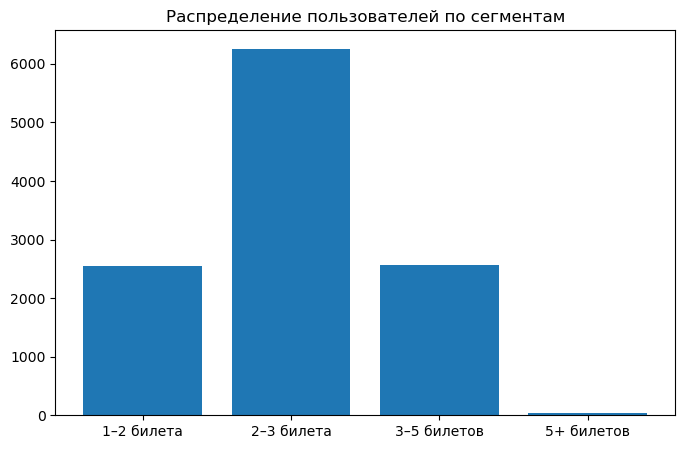

In [63]:
plt.figure(figsize=(8,5))
plt.bar(result.index, result['users_count'])
plt.title('Распределение пользователей по сегментам')
plt.show()

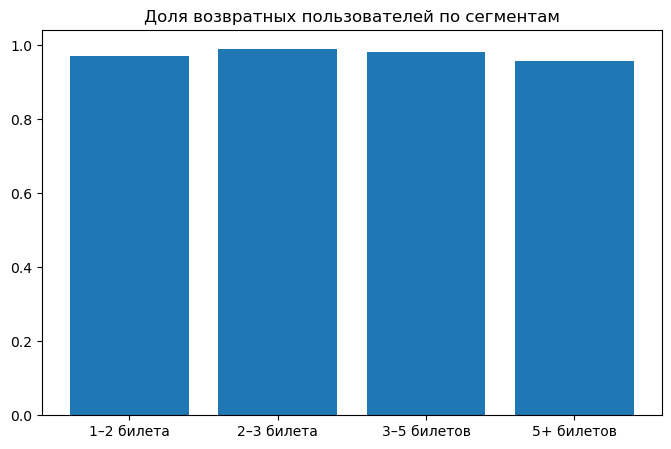

In [64]:
plt.figure(figsize=(8,5))
plt.bar(result.index, result['returned_share'])
plt.title('Доля возвратных пользователей по сегментам')
plt.show()

Основное число пользоватей (5888) совершили покупку 2-3 билетов в среднем. Наименьшая категория - пользователи, которые приобрели от 1 до 2 билетов в среднем. Другие категории представлены значительно более широко. Так, "точкой входа" можно считать пользователей, купивших два и более билетов - таких пользователей значительно больше

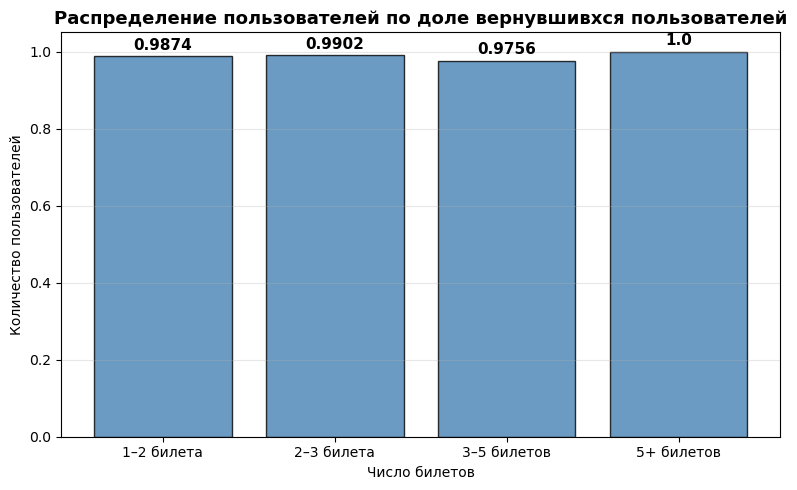

In [65]:
segments = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']
counts = [
    two_returned,
    three_returned,
    four_returned,
    five_returned
]

plt.figure(figsize=(8, 5))
bars = plt.bar(segments, counts, color='steelblue', edgecolor='black', alpha=0.8)

for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + max(counts) * 0.01,
        f"{count:,}",        
        ha='center', 
        va='bottom', 
        fontsize=11, 
        weight='bold'
    )

plt.title('Распределение пользователей по доле вернувшивхся пользователей', fontsize=13, weight='bold')
plt.ylabel('Количество пользователей')
plt.xlabel('Число билетов')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

На диаграмме предсставлено распределение вернувшхся пользователей. Как мы видим, основная масса возвращается на сервис снова. Пользователи, покупающие 5 и более билетов возвращались всегда. Меньше всего возвращались пользователи, купившие  от 1 до двух билетов, среди таких доля возврата примерно 0.49. 

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [66]:
weekdays = user_profiles_df['first_order_date'].dt.weekday
weekday_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}


pivot = pd.pivot_table(
    user_profiles_df,
    index=weekdays,              # группировка по дню недели
    values=['user_id', 'is_two'], # два столбца: id и бинарный флаг
    aggfunc={
        'user_id': 'count',       # сколько всего пользователей
        'is_two': 'mean'           # сколько из них вернулись
    }
)
pivot.index = pivot.index.map(weekday_names)
pivot.columns = ['returned', 'total']
print(pivot)

                  returned  total
first_order_date                 
Понедельник       0.984247   1587
Вторник           0.986219   1669
Среда             0.979017   1668
Четверг           0.979543   1662
Пятница           0.985899   1702
Суббота           0.988915   1714
Воскресенье       0.984496   1419


Создали сводную таблицу по дням недели. В первом столбце приведена доля вернувшихся пользователей, во втором - общее число пользователей в каждом сегменте. Далее построим визуализацию

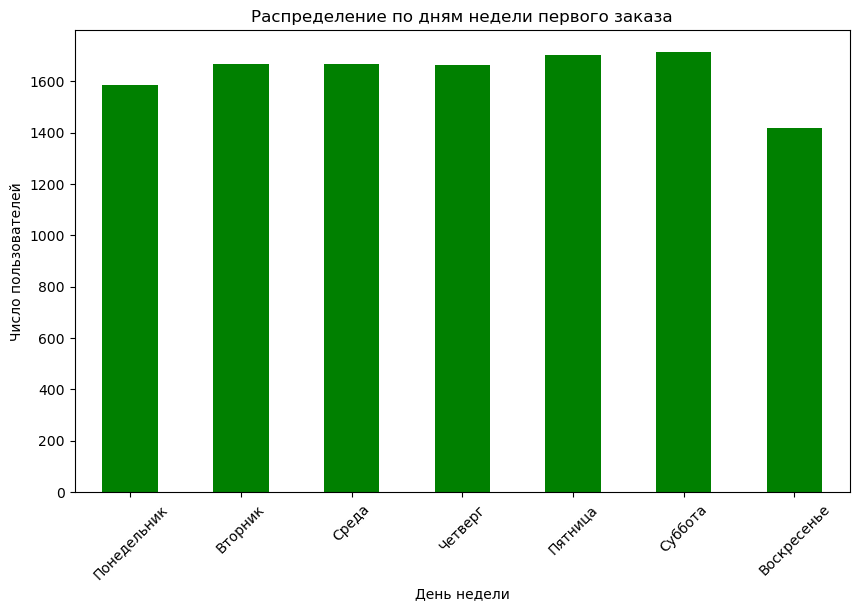

In [67]:
pivot.plot(
kind='bar',
    y = 'total',
    title='Распределение по дням недели первого заказа',
    legend = False,
    color = 'green',
    figsize=(10,6),
    rot = 45
)
plt.xlabel('День недели')
plt.ylabel('Число пользователей')
plt.show()


Основное число пользователей совершило свою первую покупку в  четверг. Проверим, имеет ли это связь с процентом возврата

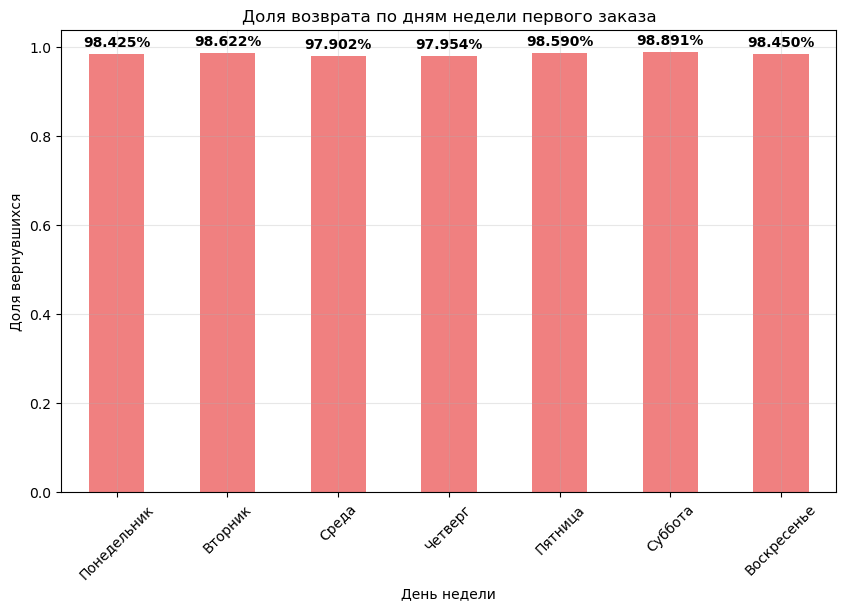

In [68]:
ax = pivot.plot(
    kind='bar',
    y='returned',                 # доля (0.35, 0.42)
    color='lightcoral',
    figsize=(10, 6),
    rot=45,
    legend=False
)

plt.title('Доля возврата по дням недели первого заказа')
plt.xlabel('День недели')
plt.ylabel('Доля вернувшихся')
plt.grid(True, alpha=0.3)

# Подписи в процентах
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3%}",
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.show()


Как следует изх диаграммы, явной разницы между днями первой покупки не обнаружено. Наименьший процент возврата у воскресенья: всего 55,3%. Наибольший: у понедельника 59%. Вероятно это связано с тем, что большинство людей строит ппланы, опираясь на начало недели.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [69]:
users_filtered_df = user_profiles_df[user_profiles_df['avg_time_between_orders'] > -1]


In [70]:
two_orders = users_filtered_df[users_filtered_df['is_two'] & ~users_filtered_df['is_five']]
five_orders = users_filtered_df[users_filtered_df['is_five']]

two_mean_time = round(two_orders['avg_time_between_orders'].mean(), 2)
five_mean_time = round(five_orders['avg_time_between_orders'].mean(), 2)

two_median_time = round(two_orders['avg_time_between_orders'].median(), 2)
five_median_time = round(five_orders['avg_time_between_orders'].median(), 2)
print(f"Для пользователей, совершивших 2-4 покупки: Медиана - {two_median_time}, среднее - {two_mean_time}")
print(f"Для пользователей, совершивших 5+ покупок: Медиана - {five_median_time}, среднее - {five_mean_time}")

Для пользователей, совершивших 2-4 покупки: Медиана - 6.5, среднее - 14.83
Для пользователей, совершивших 5+ покупок: Медиана - 9.67, среднее - 11.12


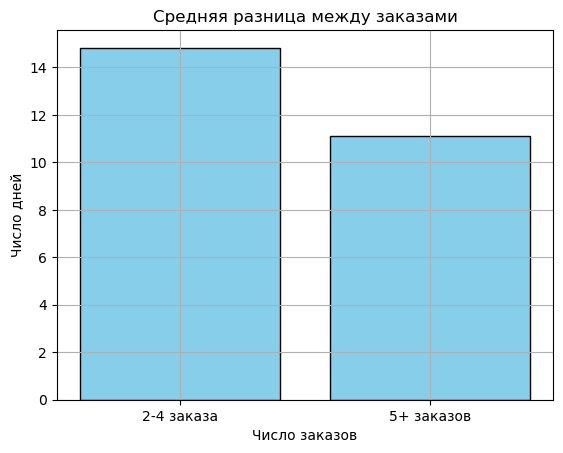

In [71]:
means = [two_mean_time, five_mean_time]
medians = [two_median_time, five_median_time]
categories = ['2-4 заказа', '5+ заказов']

bar = plt.bar(
    categories,
    means,
    color = 'skyblue',
    edgecolor =  'black'
)
plt.title('Средняя разница между заказами')
plt.ylabel('Число дней')
plt.xlabel('Число заказов')
plt.grid()
plt.show()



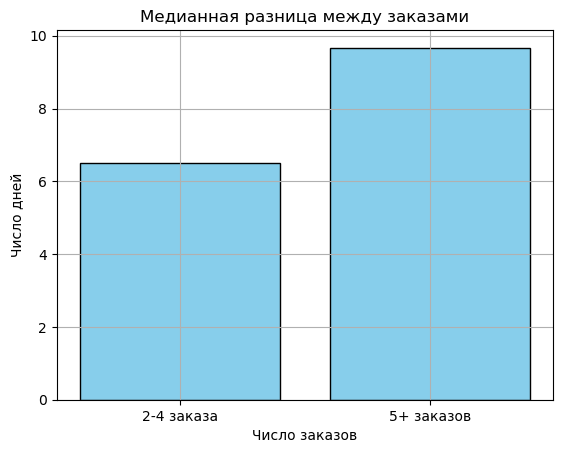

In [72]:

bar = plt.bar(
    categories,
    medians,
    color = 'skyblue',
    edgecolor =  'black'
)
plt.title('Медианная разница между заказами')
plt.ylabel('Число дней')
plt.xlabel('Число заказов')
plt.grid()
plt.show()


Как следует из представленных выше даннных, пользователи, совершившие пять и более заказов имели в среднем более долгие промежутки между заказами, нежели пользователи, совершившие 2-4. В теории, это может быть связано с более долгим "лайфтаймом", пользователи с бОльшим числом заказво просто дольше пользуются сервисом.  Пользователи, с 2-4 заказами в среднем имели разницу между покупаками 7,5 дней, а медиану - 2,5. Для пяти заказов - среднее составило 9,5 дней, а медиана - 8,6. Стоит отметить, что медиана у постоянных клиентов заметно выше, чем у непостоянных. Постоянники совершают заказы реже, однако делаюьт это регулярно
Изучим этот параметр

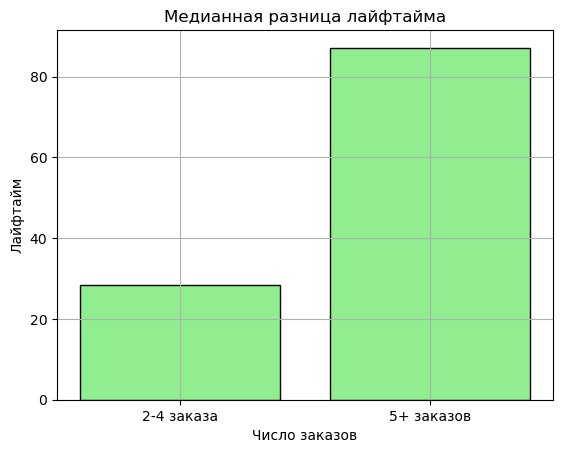

Лайфтайм пльзователей, совершивших 2-4 заказа: 28.5
Лайфтайм пльзователей, совершивших 5+ заказа: 87.18


In [73]:
lifetime_2_days = (two_orders['last_order_date'] - two_orders['first_order_date']).dt.total_seconds() / (60 * 60 * 24)
lifetime_5_days = (five_orders['last_order_date'] - five_orders['first_order_date']).dt.total_seconds() / (60 * 60 * 24)
mean_lifetime_2 = round(lifetime_2_days.mean(), 2)
mean_lifetime_5 = round(lifetime_5_days.mean(), 2)

means_lt = [mean_lifetime_2, mean_lifetime_5]

bar = plt.bar(
    categories, 
    means_lt,
    color = 'lightgreen',
    edgecolor='black',
)

plt.title('Медианная разница лайфтайма')
plt.ylabel('Лайфтайм')
plt.xlabel('Число заказов')
plt.grid()
plt.show()
print(f"Лайфтайм пльзователей, совершивших 2-4 заказа: {mean_lifetime_2}")
print(f"Лайфтайм пльзователей, совершивших 5+ заказа: {mean_lifetime_5}")

Как следует из этого графика, пользователи, совершившие 5+ заказов, имеют почти в 4 раза бОльший лайфтайм, чем пользователи, совершившие 2-4. Это объясняет, почему пользователи, имеющие меньшую разницу времени между заказами - они не так долго находятся на платформе. Однако, нельзя исключать, что пользователи, склонные совершать меньше заказов, совершают их чаще.

При этом лайфтайм пользователей, сделавших 2-4 заказа составила срелнем 24 дня, а для постоянных - почти 87 дней. Можно говорить о том, тчо чем больше пользователь нахолится на сайте, тем больше покеупок он совершит, однако с промежутком.


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [74]:

cols_for_corr = [
    'first_order_date',
    'last_order_date',
    'first_device',
    'first_region',
    'first_partner',
    'first_event_genre',
    'total_orders',                  
    'avg_revenue_per_order',
    'avg_ticket_count',
    'avg_time_between_orders'
]

df_corr = user_profiles_df[cols_for_corr].copy()


cat_cols = ['first_device', 'first_region', 'first_partner', 'first_event_genre']
for col in cat_cols:
    df_corr[col] = df_corr[col].astype('category')
interval_cols = [
    'avg_revenue_per_order',
    'avg_ticket_count',
    'avg_time_between_orders'
]

In [ ]:
phi_matrix = df_corr.phik_matrix(
    interval_cols=interval_cols,
    verbose=False
)

phi_col = phi_matrix['total_orders'].drop('total_orders')


phi_df = phi_col.to_frame()

phi_df = phi_df.sort_values('total_orders', ascending=False)
print("Корреляционные коэффициенты с числом заказов: ", phi_df)
# Строим heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(
    phi_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Phi_K'},
    square=True
)
plt.title('Phi_K: связь признаков с total_orders', fontsize=12, pad=15)
plt.tight_layout()
plt.show()

E:\conda\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable first_order_date is large: 11408. Are you sure this is not an interval variable? Analysis for pairs of variables including first_order_date can be slow.
  warnings.warn(
E:\conda\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable last_order_date is large: 11402. Are you sure this is not an interval variable? Analysis for pairs of variables including last_order_date can be slow.
  warnings.warn(


Из тепловой карты следует, что наибольшая корреляция наблюдается с средней разницей во времени между заказами. Она составила 0.701, то есть есть сильная положительная корреляция между перервом между покупками и числом заказов. Также видим сильную корреляцию с днями первого и последнего заказа: 0.409 и 0.355 соответственно. Разделим заказы на сегменты и будем считать корреляцию уже для них

In [ ]:
# Создаём сегмент
def get_segment(n):
    if n == 1:
        return '1 order'
    elif 2 <= n <= 4:
        return '2-4 orders'
    else:
        return '5+ orders'

# Добавляем сегмент в df_corr (уже есть — оставляем как есть)
df_corr['order_segment'] = df_corr['total_orders'].apply(get_segment)
df_corr['order_segment'] = df_corr['order_segment'].astype('category')

# ВАЖНО: теперь df_corr содержит 'order_segment', но НЕ содержит 'total_orders' как переменную для корреляции — мы хотим корреляцию ПРИЗНАКОВ с 'order_segment'
# Поэтому убираем 'total_orders' из анализа (оставляем все, кроме него, и добавляем 'order_segment')
feature_cols = [col for col in cols_for_corr if col != 'total_orders'] + ['order_segment']

# ВАЖНО: пересоздаём подмножество с нужными колонками (иначе phik_matrix может ругаться на типы/отсутствие)
df_for_phi_seg = df_corr[feature_cols].copy()

# Категориальные признаки (все, кроме интервальных — 'order_segment' тоже категория!)
cat_cols_for_seg = [
    'first_device', 'first_region', 'first_partner', 'first_event_genre', 'order_segment'
]
for col in cat_cols_for_seg:
    df_for_phi_seg[col] = df_for_phi_seg[col].astype('category')

# Интервальные признаки — без изменений
interval_cols = [
    'avg_revenue_per_order',
    'avg_ticket_count',
    'avg_time_between_orders'
]


phi_matrix_seg = df_for_phi_seg.phik_matrix(
    interval_cols=interval_cols,
    verbose=False
)


phi_with_segment = phi_matrix_seg.loc[
    [col for col in phi_matrix_seg.index if col != 'order_segment'],  # все признаки, кроме самой целевой
    'order_segment'
]

phi_segment_df = phi_with_segment.to_frame(name='order_segment')

phi_segment_df = phi_segment_df.sort_values('order_segment', ascending=False)
print("Корреляционные коэффициенты признаков с order_segment:\n", phi_segment_df)

# Строим heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(
    phi_segment_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Phi_K'},
    square=True
)
plt.title('Phi_K: связь признаков\nс сегментом по числу заказов', fontsize=12, pad=15)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

При делении на сегменты значения некоторых коэффициентов изменились, однако остались схожими. Наибольшая корреляция наблюдается с теми же столбцами

Вывод: были изучены коэффиценты корреляции с числом заказов пользователей. Выявлена сильная корреляция с средней разницей дней между заказами. Для обоих вариантов расчета этот показатель соствил около 0,700. Это говорит о том, что пользователи, совершающие заказы реже, в среднем совершают больше заказов. Вероятно, это пользователи, давно использующие сайт 

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

- Загружено 290 611 заказов от 21 854 уникальных пользователей (после фильтрации выбросов и дубликатов).
- Проведена полная предобработка:
- Добавлен столбец с стоимостью заказа в рублях;
- Удалено ~1 % строк (2 860) — дубликаты и выбросы по выручке (> 95%)
- Пропуски в days_since_prev заменены на -1 (для пользователей с 1 заказом).
- Создан агрегированный профиль пользователя: дата первого/последнего заказа, устройство, регион, сервис, жанр первого мероприятия, бинарные флаги для числа заказов.

 - Изучены основные параметры пользователей:
62 % пользователей сделали ≥2 заказа
29 % — Оосбенно лояльные пользователи (≥5 заказов).

Средняя выручка с заказа — 545 ₽, медиана — 545 ₽.
Среднее число билетов в заказе — 2,7, медиана — 3.
-  Что влияет на возврат? Ключевые закономерности
 1. Признаки первого заказа
   Точки входа:
 - Концерты — 44,6 % первых заказов (но возврат — 57,5 %);
 - Мобильные устройства — 82,4 % первых заказов (возврат — 58,5 %);
 - Регион — Каменевский (32,8 %);
 - Партнёр — «Билеты без проблем» (23,4 %).
 2. Наибольший возврат наблюдается у:
 - Выставок (+60 %), театров (+59 %);
 - Пользователей ПК (+59,4 % против 58,5 % у мобильных);
 - Святополянского округа (+62 %);
 - Партнёра «Край билетов» (+64 %).
 -  <b>Вывод:</b> тип мероприятия и партнёр сильнее влияют на лояльность, чем устройство или регион.
 3. Связь средней выручки с вероятностью повторных покупок
 Были изучены распределения средней выручки, сделан следующий вывод. Пользователи, совершавшие больше заказов, в среднем имели более выскоий средний чек. Так, пользователи совершившие 5+ заказов имеют наибольший чек и по медиане, и по среднему. Вероятно, это связано с тем, что пользователи, совершающие заказы чаще более лояльны и готовы тратить большие суммы на билеты. 
 4. Была исследована зависимость дня первой покупки и процетом возврата. Наибольшее число пользователей совершили первую покупку в четверг, однако это не имело связи с частотой возврата. Процент повторных клиентов был примерно на одном уровне для всех категорий. Затем было посчитано значение средней разницы в днях меджу заказами. Было обнаружено, что пользователи, совершающие больше заказов, имеют больший интервал между покупками. Чтобы изучить эту связь более точно, было изучено значение лайфтайма - разницы между последним и первым заказом. Выяснено, что пользователи, совершившие больше заказов в среднем пребывают на платформе значитеьно дольше, чем пользователи с меньшим числом заказов. 
 5. Были изучены коэффициенты корреляции между различными показателями первой покупки пользователя и его числом заказов. Выявлена следующая взаимосвязь - пользователи, у которых разница в между заказами имеет большее значение, имеют большее число заказов. Это подстверждает догадки из прошлого пункта. В целом можно сделать вывод, что основную массу заказов совершают постоянные клиенты, которые давно на платформе. 


### Общие рекомендации

1. Фокус на «высокопотенциальных точках входа»
Цель: превращать новых пользователей в лояльных и постоянных.

- Повысить видимость мероприятий с высокой вовлечённостью:
Запустить персонализированные баннеры/рекомендации для пользователей, зашедших на выставки и театры — у них возврат +60 % и +59 %, что на 6–7 п.п. выше среднего.
 - Усилить  партнёрство с сервисом «Край билетов»:
Этот партнёр показывает самый высокий возврат (64 %) — даже при меньшей доле пользователей.
 -  Стимулировать «групповые заказы» — ключевой индикатор лояльности
Цель: перевести пользователей из сегмента «1–2 билета» (возврат ~49 %) в «≥3 билета» (возврат >85 %).

 -  Внедрение механики групповой выгоды:
«3 билета — скидка 20 %», «5+ билетов — бесплатная доставка»; 

- Оптимизировать онбординг для мобильных пользователей
Несмотря на то, что 82 % приходят с мобильных, возврат у ПК-пользователей выше (59,4 % vs 58,5 %).
Проверить мобильное приложение на возмодные баги и недостатки UI дизайна, которые мешают возвраты пользователей.

-  Работать с постоянными пользователями, работаьт над их удержанием
Пользователи с ≥5 заказов имеют в 4× больший лайфтайм и более высокий чек.

 -  Выделите сегмент «активных пользователей (>30 дней на платформе)» и:
Внедрите программу лояльности: баллы за каждый заказ, кэшбэк.
Запустите персонализированные email-рассылки с подборками «Вам понравились прошлые концерты — вот новинки».
-  Анализируйте отток «долгожителей»:
Если пользователь не заходил >14 дней после последнего заказа — отправляйте «реактивационное» предложение.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/verrra25/proj_2/tree/master

Отмечу, файл .env не включен в репозиторий